In [1]:
#hide
%matplotlib inline
import datetime

import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm
import theano.tensor as tt
from sunode.wrappers.as_theano import solve_ivp

import requests
import io

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Data

In [2]:
#hide

def load_timeseries(name, 
                    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'):
    import requests
    # Thanks to kasparthommen for the suggestion to directly download
    url = f'{base_url}/time_series_19-covid-{name}.csv'
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'
    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, 
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     .rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])
    return df

df_confirmed = load_timeseries('Confirmed')
# Drop states for simplicity
df_confirmed = df_confirmed.loc[df_confirmed.state.isnull()]
# Estimated critical cases
p_crit = .05
df_confirmed = df_confirmed.assign(cases_crit=df_confirmed.cases*p_crit)

# Compute days relative to when 100 confirmed cases was crossed
df_confirmed.loc[:, 'days_since_100'] = np.nan
for country in df_confirmed.country.unique():
    df_confirmed.loc[(df_confirmed.country == country), 'days_since_100'] = \
        np.arange(-len(df_confirmed.loc[(df_confirmed.country == country) & (df_confirmed.cases < 100)]), 
                  len(df_confirmed.loc[(df_confirmed.country == country) & (df_confirmed.cases >= 100)]))
    
# Select countries for which we have at least some information
countries = pd.Series(df_confirmed.loc[df_confirmed.days_since_100 >= 2].country.unique())
# We only have data for China after they already had a significant number of cases.
# They also are not well modeled by the exponential, so we drop them here for simplicity.
#countries = countries.loc[~countries.isin(['China (total)', 'Cruise Ship (total)'])]
countries = countries.loc[~countries.isin(['Cruise Ship (total)'])]
df_sign = df_confirmed.loc[lambda x: x.country.isin(countries) & (x.days_since_100 >= 0)]
n_countries = len(countries)
countries = countries.rename('country').to_frame().set_index('country')

In [3]:
df_sign = df_sign.reset_index()
df_sign.index.name = 'observation'

previous = (
    df_sign
    .reset_index()
    .groupby('country')
    .apply(
        lambda x:
        x.set_index('date')
        .assign(date=x.date.values)
        .sort_index()
        .shift()
    )
)

df_sign = (
    df_sign
    .reset_index()
    .set_index(['country', 'date'])
    .assign(
        previous_date=previous.date,
        previous_cases=previous.cases,
    )
    .reset_index()
    .set_index('observation')
)

df_sign['new_cases'] = df_sign.eval('cases - previous_cases')
df_sign['days_since_last_data'] = (df_sign['date'] - df_sign['previous_date']).dt.days
df_sign = df_sign.dropna(subset=['new_cases'])

## Growth Rate Predictions

In [4]:
pop_file = 'https://github.com/datasets/population/raw/master/data/population.csv'
populations = pd.read_csv(pop_file)
populations = populations.sort_values(['Country Name', 'Year']).groupby(['Country Name']).last()

idxs = populations.index.get_indexer([c.replace('(total)', '').strip() for c in countries.index])
countries['population'] = [populations.iloc[i].Value if idx != -1 else pd.NA for i, idx in enumerate(idxs)]

In [5]:
countries.loc['Egypt', 'population'] = populations.loc['Egypt, Arab Rep.'].Value
countries.loc['Iran', 'population'] = populations.loc['Iran, Islamic Rep.'].Value
countries.loc['Korea, South', 'population'] = populations.loc['Korea, Rep.'].Value
countries.loc['Hong Kong', 'population'] = populations.loc['Hong Kong SAR, China'].Value
countries.loc['Czechia', 'population'] = populations.loc['Czech Republic'].Value
countries.loc['US (total)', 'population'] = populations.loc['United States'].Value

In [6]:
countries['population'] = countries.population.astype('d')

In [7]:
multi_country = False
country = 'Italy'

countries = countries.loc[country: country]
df_sign = df_sign[df_sign.country == country]
n_countries = 1

In [8]:
start_day = df_sign.date.min() - datetime.timedelta(days=1)
end_data_day = df_sign.date.max()
end_day = end_data_day + datetime.timedelta(days=30)

data_time = pd.date_range(start_day, end_data_day)
time = pd.date_range(start_day, end_day)
country = countries.index

In [9]:
import sunode

In [10]:
def sir_rhs(t, y, p):
    infections = y.infection_rate * y.S * y.I
    remissions = p.remission_rate * y.I
    
    change = [
        sunode.symode.lambdify.interpolate_spline(t, p.infection_change_polys[i], 0, len(data_time), degree=4)
        for i in range(len(infections))
    ]

    return {
        'S': -infections,
        'I': infections - remissions,
        'R': remissions,
        'infection_rate': change,
    }

with pm.Model() as model:
    if multi_country:
        sd = pm.HalfNormal('init_logI_sd')
        mu = pm.Normal('init_logI_mu')
        raw = pm.Normal('init_logI_raw', shape=n_countries)
        init_logI = mu + sd * raw
        pm.Deterministic('init_logI', init_logI)
    else:
        init_logI = pm.Normal('init_logI', shape=n_countries)
        init_logI = init_logI - np.log(countries['population'].values)

    if multi_country:
        sd = pm.HalfNormal('log_infect_sd')
        mu = pm.Normal('log_infect_mu')
        raw = pm.Normal('log_infect_raw', shape=n_countries)
        log_infect = mu + sd * raw
        pm.Deterministic('log_infect', log_infect)
    else:
        log_infect = pm.Normal('log_infect', shape=n_countries)

    if multi_country:
        sd = pm.HalfNormal('log_remiss_sd')  # In 1/day/infected
        mu = pm.Normal('log_remiss_mu')
        raw = pm.Normal('log_remiss_raw', shape=n_countries)
        log_remiss = mu + sd * raw
        pm.Deterministic('log_remiss', log_remiss)
    else:
        log_remiss = pm.Normal('log_remiss', shape=n_countries)
        
    sd = pm.HalfNormal('infection_change_polys_sd')
    raw = pm.Normal('infection_change_polys_raw', shape=(n_countries, 8))
    infection_change_polys = sd * raw

    init = {
        'S': (1 - tt.exp(init_logI), (n_countries,)),
        'I': (tt.exp(init_logI), (n_countries,)),
        'R': np.zeros(n_countries),
        'infection_rate': (tt.exp(log_infect), (n_countries,)),
    }
    
    params = {
        #'infection_rate': (tt.exp(log_infect), (n_countries,)),
        'remission_rate': (tt.exp(log_remiss), (n_countries,)),
        'infection_change_polys': (infection_change_polys, (n_countries, 8)),
        '_placeholder': np.zeros(1),
    }
    
    solution, flat_solution, problem, solver, *_ = solve_ivp(
        t0=0,
        y0=init,
        params=params,
        tvals=np.arange(len(data_time)),
        rhs=sir_rhs
    )

    for name in init:
        pm.Deterministic(f'solution_{name}', solution[name])

    cases = (solution['I'] + solution['R']) * countries.population.values[None, :].astype(float)
    #cases = solution['I'] * countries.population.values[None, :]

    idx_country = countries.index.get_indexer(df_sign.country)
    idx_data_time = data_time.get_indexer(df_sign.date)
    assert -1 not in idx_country
    assert -1 not in idx_data_time
    
    sigma = pm.HalfNormal('observed_infected_sigma', shape=n_countries)
    mu = cases[idx_data_time, idx_country]
    pm.Deterministic('mu', mu)
    pm.NegativeBinomial(
        'observed_count',
        mu,
        sigma[idx_country],
        observed=df_sign['cases'].values)

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [11]:
lib = sunode._cvodes.lib
lib.CVodeSStolerances(solver._ode, 1e-10, 1e-10)
lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-8, 1e-8)
lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-8, 1e-8)
lib.CVodeSetMaxNumSteps(solver._ode, 5000)
lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 5000)
lib.CVodeSetMaxOrd(solver._ode, 4)
lib.CVodeSetMaxOrdB(solver._ode, solver._odeB, 4)
#lib.CVodeSetMaxStep(solver._ode, 120)
#lib.CVodeSetMaxStepB(solver._ode, solver._odeB, 300)

0

In [13]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observed_infected_sigma, infection_change_polys_raw, infection_change_polys_sd, log_remiss, log_infect, init_logI]


/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6921039813468606, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6412410039988085, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning

In [14]:
import arviz
tr = arviz.from_pymc3(
    trace=trace,
    coords={
        'data_time': data_time,
        'country': country,
        'time': time,
        'observation': df_sign.index,
        'infection_poly': np.arange(8),
    },
    dims={
        'init_logI_raw': ['country'],
        'init_logI': ['country'],
        'log_infect_raw': ['country'],
        'log_infect': ['country'],
        'log_remiss_raw': ['country'],
        'log_remiss': ['country'],
        'solution_I': ['data_time', 'country'],
        'solution_S': ['data_time', 'country'],
        'solution_R': ['data_time', 'country'],
        'solution_infection_rate': ['data_time', 'country'],
        'infection_change_polys_raw': ['country', 'infection_poly'],
        'infection_change_polys': ['country', 'infection_poly'],
        'observed_infected_sigma': ['country'],
        'mu': ['observation'],
    },
    log_likelihood=False,
).posterior

In [15]:
import xarray as xr

In [16]:
xr.DataArray(countries['population'])

<xarray.DataArray 'population' (country: 1)>
array([4.0645269e+08])
Coordinates:
  * country  (country) object 'Italy'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4030e51350>,
      dtype=object)

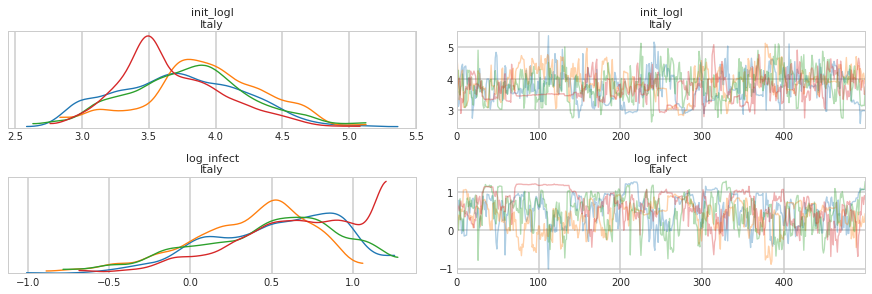

In [17]:
arviz.plot_trace(tr, var_names=['init_logI', 'log_infect'])

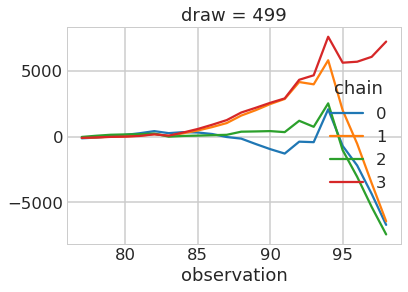

In [18]:
(tr.mu - xr.DataArray(df_sign.cases, dims=('observation',))).isel(draw=-1).plot.line(x='observation')

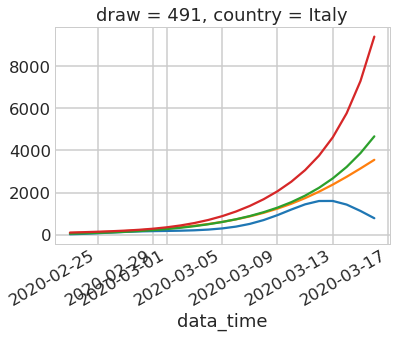

In [19]:

(tr.solution_I * xr.DataArray(countries['population'])).isel(country=0, draw=-9).plot.line(x='data_time', add_legend=False);

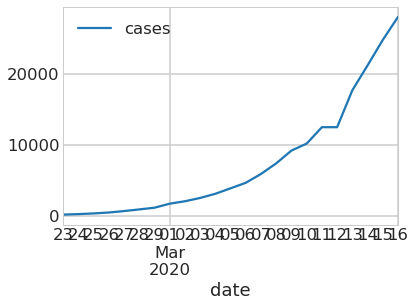

In [74]:
df_sign.plot.line(x='date', y='cases')